In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Keras imports
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Input

In [47]:
# from google.colab import drive
# drive.mount('/content/drive')

In [48]:
def load_train_data(dir):

  datagen = ImageDataGenerator(rescale=1./255)
  generator = datagen.flow_from_directory(
      dir,
      target_size=(224, 224),
      seed = 123,
      batch_size=32,
      class_mode="binary")
  return generator


In [49]:
whole_dir = '../hotdog-nothotdog/'
train_generator = load_train_data(whole_dir+'train')

Found 4242 images belonging to 2 classes.


In [50]:
train_generator.class_indices

{'hotdog': 0, 'nothotdog': 1}

In [51]:
# prompt: get an array for all images information from train_generato
file_paths = train_generator.filepaths
labels = train_generator.classes  # Assuming binary classification, 0 or 1

# Create DataFrame
data = {'file_path': file_paths, 'label': labels}
train_df = pd.DataFrame(data)

In [52]:
train_df

,file_path,label
0,../hotdog-nothotdog/train/hotdog/1.jpg,0
1,../hotdog-nothotdog/train/hotdog/10.jpg,0
2,../hotdog-nothotdog/train/hotdog/100.jpg,0
3,../hotdog-nothotdog/train/hotdog/1000.jpg,0
4,../hotdog-nothotdog/train/hotdog/1000288.jpg,0
...,...,...
4237,../hotdog-nothotdog/train/nothotdog/99136.jpg,1
4238,../hotdog-nothotdog/train/nothotdog/99201.jpg,1
4239,../hotdog-nothotdog/train/nothotdog/99604.jpg,1
4240,../hotdog-nothotdog/train/nothotdog/99890.jpg,1


In [53]:
train_ds = image_dataset_from_directory(
    '../hotdog-nothotdog/train',
    labels='inferred',
    label_mode='binary',
    image_size=[224, 224],
    interpolation='nearest',
    batch_size=32,
    subset = 'training',
    seed=123,
    validation_split=0.2,
    shuffle=True,
).map(lambda x,y: (x/255, y))


valid_ds = image_dataset_from_directory(
    '../hotdog-nothotdog/train',
    labels='inferred',
    label_mode='binary',
    image_size=[224, 224],
    interpolation='nearest',
    batch_size=32,
    subset = 'validation',
    seed=123,
    validation_split=0.2,
    shuffle=True,
).map(lambda x,y: (x/255, y))


Found 4242 files belonging to 2 classes.
Using 3394 files for training.
Found 4242 files belonging to 2 classes.
Using 848 files for validation.


In [54]:
conv_base = VGG16(
    weights='imagenet',
    include_top=False
)

for layer in conv_base.layers:
    layer.trainable = False

In [55]:
data_aug = keras.models.Sequential([
    RandomFlip('horizontal_and_vertical', input_shape=(224, 224, 3)),
    RandomRotation(0.2),
    RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
])

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [56]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_aug(inputs)
# Only necessary since we did a data augmentation step!
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

model_pret = keras.Model(inputs, outputs)

In [57]:
model_pret.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['acc']
)

In [58]:
# hist_pret = model_pret.fit(train_ds, validation_data=valid_ds, epochs=1)

In [75]:
# Define the input shape
input_shape = (224, 224, 3)

model = keras.models.Sequential([
    # Input layer with specified shape
    Input(shape=input_shape),
    # First convolutional layer
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    # Data augmentation layers
    RandomFlip('horizontal_and_vertical'),
    RandomRotation(0.3),
    RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
    # Second convolutional layer
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(2),
    # Third convolutional layer
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(2),
    # Flatten layer to concert 2D feature maps to 1D feature vectors
    Flatten(),
    # Fully connected layer with 16 neurons
    Dense(16, activation='relu'),
    # Dropout layer to prevent overfitting
    Dropout(0.5),
    # Output layer
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

In [76]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
hist = model.fit(
    train_ds, 
    validation_data=valid_ds, 
    epochs=50,
    callbacks=[early_stopping]
    )

Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - acc: 0.5176 - loss: 0.6917 - val_acc: 0.4965 - val_loss: 0.6916
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 106s 989ms/step - acc: 0.5036 - loss: 0.6931 - val_acc: 0.6356 - val_loss: 0.6233
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 105s 977ms/step - acc: 0.6175 - loss: 0.6768 - val_acc: 0.6344 - val_loss: 0.6348
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 105s 978ms/step - acc: 0.6149 - loss: 0.6523 - val_acc: 0.6627 - val_loss: 0.6052
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 105s 983ms/step - acc: 0.6343 - loss: 0.6427 - val_acc: 0.6851 - val_loss: 0.5978
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - acc: 0.6223 - loss: 0.6377 - val_acc: 0.6969 - val_loss: 0.5871
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - acc: 0.6473 - loss: 0.6275 - val_acc: 0.6875 - val_loss: 0.5881
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 106s 989ms/step - acc: 0.6240 - loss: 0.6445 - val_acc: 0.6875 - val_loss: 0.5879
Epoch 9/50
107/107 ━━━━━━━━━━━━━━

In [78]:
model.save('../Models/yc_model_k.keras')

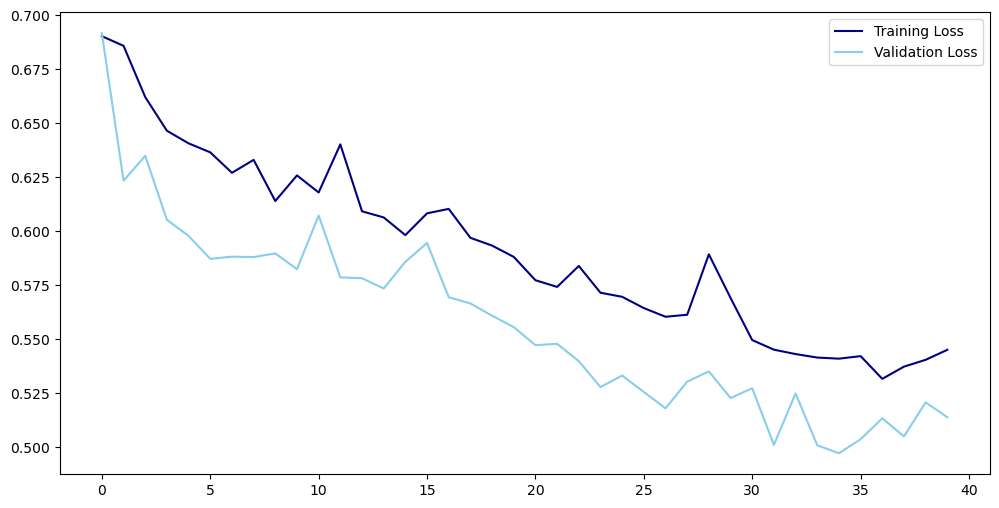

In [77]:
plt.figure(figsize=(12, 6))
plt.plot(hist.history['loss'], c='navy', label='Training Loss')
plt.plot(hist.history['val_loss'], c='skyblue', label='Validation Loss')
plt.legend();

In [ ]:
model.save("/content/yc_model.keras")

In [ ]:
model_json = model.to_json()

# Save model architecture to a JSON file
with open("/content/model_architecture.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
import pickle

In [ ]:
with open('/content/yc_model.pkl', 'wb') as f:
    pickle.dump(model, f)

## Testing

In [80]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [84]:
test_pic = '../hotdog-nothotdog/train/nothotdog'

def preprocess_image(image):
    # Resize the image to match the input size of your CNN model
    image = image.resize((224, 224))  # Assuming your model expects 224x224 input
    # Convert the image to a numpy array
    image_array = img_to_array(image)
    # Normalize the pixel values to be in the range [0, 1]
    image_array = image_array / 255.0
    # Expand the dimensions to create a batch of size 1
    image_array = np.expand_dims(image_array, axis=0)
    return image_array



img_path = os.path.join(test_pic, '94.jpg')
img = load_img(img_path, target_size=(224, 224)) 

preprocessed_image = preprocess_image(img)

pred = model.predict(preprocessed_image)

pred[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


0.7710672